<a href="https://colab.research.google.com/github/saisuresh1999/Face-Mask-Detetction/blob/master/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
DIRECTORY = r"/content/drive/My Drive/face mask detection/dataset2"
CATEGORIES = ["with_mask", "without_mask"]


In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    print("path",path)
    for img in os.listdir(path):
      #print("img",img)
      img_path = os.path.join(path, img)
      #print("img_path",img_path)
      image = load_img(img_path, target_size=(224, 224))
      #print(type(image))
      #print("image1",image) #image1 <PIL.Image.Image image mode=RGB size=224x224 at 0x7F015B575940>
      image = img_to_array(image)
      #print(type(image))
      #print(image.shape)
      #print(image[0][0])
      image = preprocess_input(image)
      #print(image[0][0])
      #print(type(image))
      data.append(image)
      labels.append(category)
      #break
#print(data)
#print(len(data))
#print(labels)
#print(len(labels))

path /content/drive/My Drive/face mask detection/dataset2/with_mask


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


path /content/drive/My Drive/face mask detection/dataset2/without_mask


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#print(labels)
labels = to_categorical(labels)
#print(labels)
data = np.array(data, dtype="float32")
labels = np.array(labels)
#print(labels)



In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [15]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
	layer.trainable = False

In [12]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [16]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 33s 344ms/step - loss: 0.3480 - accuracy: 0.8464 - val_loss: 0.0992 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 32s 333ms/step - loss: 0.1175 - accuracy: 0.9618 - val_loss: 0.0598 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 32s 334ms/step - loss: 0.0780 - accuracy: 0.9776 - val_loss: 0.0471 - val_accuracy: 0.9883
Epoch 4/20
95/95 [==============================] - 32s 333ms/step - loss: 0.0764 - accuracy: 0.9723 - val_loss: 0.0414 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 32s 332ms/step - loss: 0.0608 - accuracy: 0.9802 - val_loss: 0.0331 - val_accuracy: 0.9961
Epoch 6/20
95/95 [==============================] - 31s 328ms/step - loss: 0.0527 - accuracy: 0.9848 - val_loss: 0.0296 - val_accuracy: 0.9948
Epoch 7/20
95/95 [==============================] - 31s 330ms/step - loss: 0.0480 - accuracy: 0.9819 - val_loss: 0.029

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       383
without_mask       0.99      1.00      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767

[INFO] saving mask detector model...


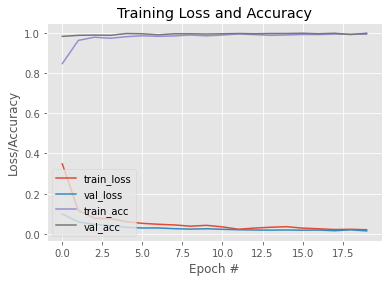

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")